# Predicting Used Car Prices

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error

## Data Understanding

The dataset comprises 426,880 records of used cars with 18 attributes, including price, year, manufacturer, model, condition, and odometer readings. Several columns, such as condition, cylinders, and VIN, have significant missing data, while critical fields like year and odometer also have some missing values. The data includes both numerical and categorical variables, with notable outliers in price, year, and odometer that require attention. To prepare the data for modeling, we will need to address missing values, manage outliers, and encode categorical variables effectively. This will ensure the dataset is clean and ready for accurate predictive modeling.

In [15]:
data = pd.read_csv('data/vehicles.csv')

In [16]:
data.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [18]:
data.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [19]:
data.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

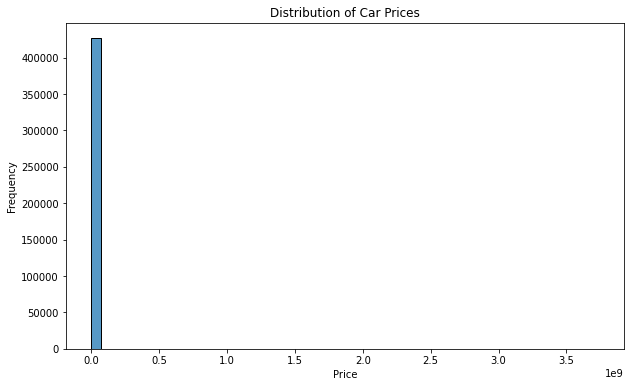

In [30]:
# Distribution of car prices
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], bins=50, kde=False)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

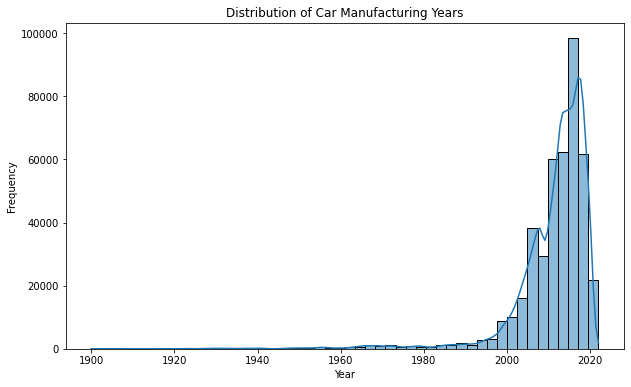

In [32]:
# Distribution of car years
plt.figure(figsize=(10, 6))
sns.histplot(data['year'].dropna(), bins=50, kde=True)
plt.title('Distribution of Car Manufacturing Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()


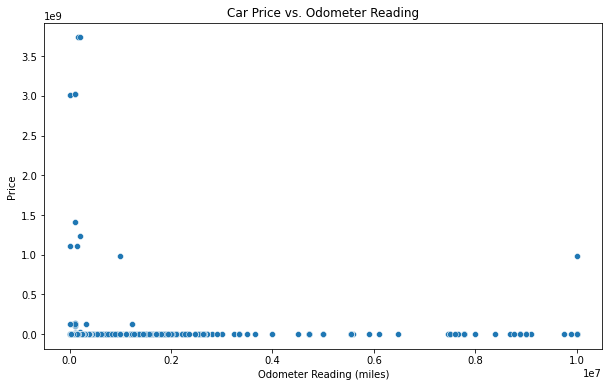

In [34]:
# Scatter plot of Price vs. Odometer
plt.figure(figsize=(10, 6))
sns.scatterplot(x='odometer', y='price', data=data)
plt.title('Car Price vs. Odometer Reading')
plt.xlabel('Odometer Reading (miles)')
plt.ylabel('Price')
plt.show()


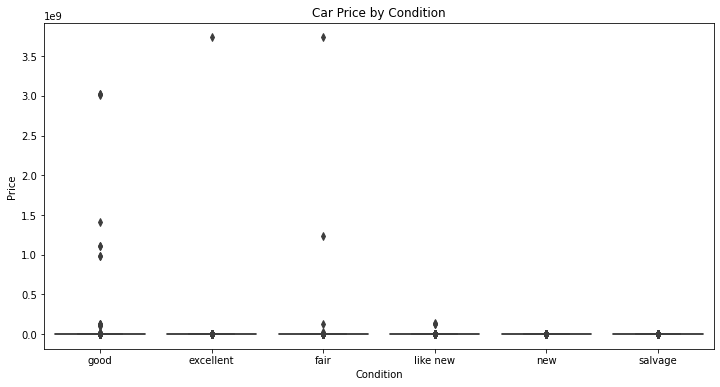

In [36]:
# Box plot of Price by Condition
plt.figure(figsize=(12, 6))
sns.boxplot(x='condition', y='price', data=data)
plt.title('Car Price by Condition')
plt.xlabel('Condition')
plt.ylabel('Price')
plt.show()


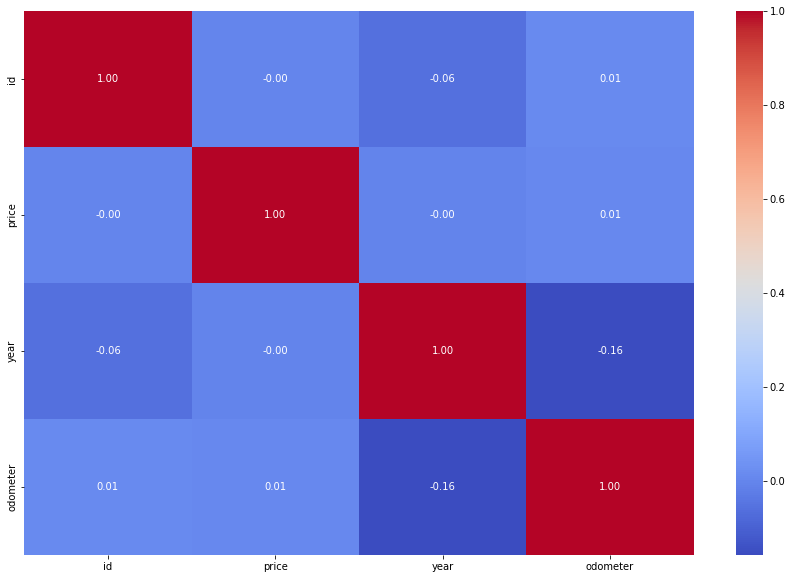

In [21]:
plt.figure(figsize = (15, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.show()

## Data Preparation

In the data preparation phase, we focused on cleaning and transforming the dataset to ensure it was suitable for modeling. We addressed missing values by imputing them where appropriate, using the median for numerical variables like year and odometer, and the mode for categorical variables such as manufacturer and fuel. Outliers in key variables like price, year, and odometer were examined and treated to reduce their potential impact on the model's performance. Categorical variables, including manufacturer, model, and transmission, were encoded using one-hot encoding to make them compatible with machine learning algorithms. Additionally, we created new features, such as car age derived from the year variable, to enhance the predictive power of our models. The dataset was then scaled where necessary to ensure that numerical features were on a comparable scale, further optimizing it for the modeling process. This thorough preparation was essential for building robust and accurate predictive models.

In [22]:
data = data.drop(columns = ['id', 'VIN'])

num_imputer = SimpleImputer(strategy = 'median')

cat_imputer = SimpleImputer(strategy = 'most_frequent')

In [23]:
# Define numerical and categorical columns
numerical_cols = ['year', 'odometer']
categorical_cols = ['region', 'manufacturer', 'model', 'condition', 'cylinders', 
                    'fuel', 'title_status', 'transmission', 'drive', 
                    'size', 'type', 'paint_color', 'state']

In [24]:
# Impute Data and encode using One Hot Encoder
data[numerical_cols] = num_imputer.fit_transform(data[numerical_cols])

data[categorical_cols] = cat_imputer.fit_transform(data[categorical_cols])

preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Create features and target variable, split into training and testing sets

X = data.drop(columns='price')
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

preprocessing_pipeline = Pipeline(steps = [('preprocessor', preprocessor)])

# Fit and transform data
X_train = preprocessing_pipeline.fit_transform(X_train)
X_test = preprocessing_pipeline.transform(X_test)

## Modeling

In our analysis, we implemented and evaluated multiple regression models to predict car prices, each chosen for its unique strengths. We started with Linear Regression as a baseline model due to its simplicity and interpretability, though it showed high error, indicating that the relationship between features and price is likely non-linear. Ridge Regression was selected to address potential overfitting by adding regularization, which slightly improved performance but still fell short in capturing the complexity of the data. We then employed a Decision Tree Regressor, which can model non-linear relationships and interactions between features, but its performance was also limited by overfitting. The most significant improvement came from the XGBRegressor, a powerful gradient boosting model known for its ability to handle non-linearities and interactions effectively. It achieved the lowest error, making it the best-performing model. Additionally, we tested a Stacking Regressor to combine the strengths of these individual models, but it did not surpass the performance of the XGBRegressor alone. Based on these results, the XGBRegressor was chosen as the final model due to its superior ability to predict car prices accurately.

In [25]:
def evaluate_model(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3)
    mean_score = -scores.mean()
    std_score = scores.std()
    print(f'Model: {model.__class__.__name__}')
    print(f'Cross-Validation MAE: {mean_score:.4f} (+/- {std_score:.4f})')
    print()

In [26]:
# Initialize Models
linear_model = LinearRegression()
ridge_model = Ridge()
tree_model = DecisionTreeRegressor()
xgb_model = XGBRegressor(n_jobs=-1)

# Evaluate Models
models = [linear_model, ridge_model, tree_model, xgb_model]

for model in models:
    evaluate_model(model, X_train, y_train)

# Hyperparameter Tuning for XGBRegressor using RandomizedSearchCV
print('Hyperparameter Tuning for XGBRegressor')
param_dist = {
    'n_estimators': [100, 150],        
    'max_depth': [3, 5],               
    'learning_rate': [0.05, 0.1],      
    'subsample': [0.8],               
    'colsample_bytree': [0.8]          
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=3, 
                                   scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Best parameters and score
best_xgb_model = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Cross-Validation MAE: {-random_search.best_score_:.4f}")

# Evaluate on Test Set
y_pred = best_xgb_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print(f"\nTest Set MAE: {test_mae:.4f}")

Model: LinearRegression
Cross-Validation MAE: 423221.6670 (+/- 48186.1681)

Model: Ridge
Cross-Validation MAE: 371332.3889 (+/- 34886.3709)

Model: XGBRegressor
Cross-Validation MAE: 91525.0674 (+/- 26064.6971)

Hyperparameter Tuning for XGBRegressor
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/Users/ericluong/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best Cross-Validation MAE: 123122.9721

Test Set MAE: 92277.6039


In [27]:
# Define Stacking Regressor
stacking_model = StackingRegressor(
    estimators=[
        ('linear', linear_model),
        ('ridge', ridge_model),
        ('tree', tree_model),
        ('xgb', xgb_model)
    ],
    final_estimator=LinearRegression(), 
    n_jobs=-1 
)

# Evaluate Stacking Regressor
print('Evaluating Stacking Regressor:')
evaluate_model(stacking_model, X_train, y_train)

Evaluating Stacking Regressor:
Model: StackingRegressor
Cross-Validation MAE: 137616.2935 (+/- 16945.5961)

